In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

In [2]:
F_ok = 110
F_ob = 50
L = 0.1
lambdas = {
    "na": 5893,
    "orange": 5780,
    "green": 5461,
    "yellow": 5780,
}

In [3]:
data = {
    "na": pd.read_csv("na.csv"),
    "orange": pd.read_csv("orange.csv"),
    "green": pd.read_csv("green.csv"),
    "yellow": pd.read_csv("yellow.csv"),
}

In [4]:
def linear_func(x, k, b):
    return k*x + b

In [49]:
def plot(x, y, function=linear_func, ejects=None, xlabel="", ylabel="", figsize=(12, 6), title="",
         dots_legend="", approx_legend="", name="graph"):
    '''
    Строит график и аппроксимирует его функцией


    x: массив иксов

    y: массив игриков

    function: функция, которой аппроксимируем, если передать None, то не аппроксимируем

    ejects: список индексов точек, которые считаем выбросами (их выбрасываем)

    xlabel: название оси x

    ylabel: название оси y

    figsize: размер графика

    title: название графика

    dots_legend: Подпись для точек

    approx_legend: Подпись для аппроксимации

    name: имя под которым сохраним график, если передать None, то не сохраним

    return popt -- параметры функции
    '''
    if ejects is not None:
        ejects = set(ejects)
    assert len(x) == len(y), "x and y must be the same size"

    if function is not None and ejects is not None:
        x_new, y_new = [], []
        for i in range(len(x)):
            if i not in ejects:
                x_new.append(x[i])
                y_new.append(y[i])
    else:
        x_new, y_new = x, y

    if function is not None:
        popt, *_ = curve_fit(function, xdata=x_new, ydata=y_new)

        x_model = np.linspace(min(x), max(x), 1000)
        y_model = function(x_model, *popt)

    
    plt.figure(figsize=figsize)
    plt.grid(True, linestyle="--")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.plot(x, y, "+r", label=dots_legend)
    if function is not None:
        plt.plot(x_model, y_model, color="blue", label=approx_legend)
    plt.legend()
    if name is not None:
        plt.savefig(f"{name}.pdf", format="pdf")

    return popt

**Пункт 1**

In [39]:
y_green = []
len(data["green"]["x_down"])
x_green = np.arange(min(len(data["green"]["x_down"].dropna()), len(data["green"]["x_up"].dropna()))) + 1

for i in range(len(x_green)):
    y_green.append(
        (data["green"]["x_up"][i] - data["green"]["x_down"][i]) ** 2
    )

y_green = np.array(y_green)

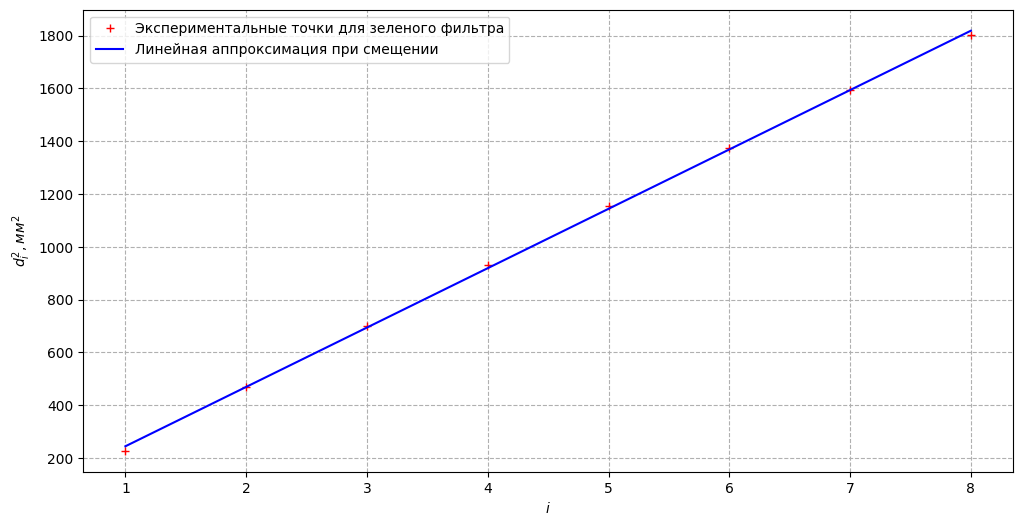

In [50]:
popt_green = plot(x_green, y_green, function=linear_func, xlabel=r"$i$", ylabel=r"$d_i^2, мм^2$", 
     dots_legend="Экспериментальные точки для зеленого фильтра",
     approx_legend="Линейная аппроксимация при смещении", name="graph_green")

In [51]:
L = lambdas["green"] / 10**10 * 4 * F_ok ** 2 / popt_green[0]
print(f"L = {(L*1000):.3f} mm")

L = 0.118 mm


**Пункт 2**

In [32]:
def get_center_coordinate(x):
    '''
    Считает центр колец


    x: pd штука в формате как ниже

    return x_center -- координата центра колец
    '''
    centers = []
    for i in range(len(x.dropna())):
        centers.append(
            (x["x_up"][i] + x["x_down"][i]) / 2
        )
    return np.mean(centers)

In [23]:
data["yellow"]

,N_down,x_down,N_up,x_up,Unnamed: 4
0,8,160.911,-8.0,192.714,176.8125
1,9,159.661,-9.0,193.921,176.7910
2,10,159.073,-10.0,194.483,176.7780
3,11,158.080,-11.0,195.552,176.8160
4,12,157.507,-12.0,196.015,176.7610
5,13,156.528,-13.0,196.960,176.7440
6,14,156.126,-14.0,197.439,176.7825
7,15,155.194,NaN,NaN,NaN
8,16,154.801,NaN,NaN,NaN
9,17,153.973,NaN,NaN,NaN


In [31]:
def get_delta_and_overline(data, first_even=True):
    '''
    Считает штуки для второго пункта, предполагаем что первое

    data: pd штука в формате как выше
    first_even: если True, то первое кольцо четный номер, а значит его скипаем, ведь у него нет пары

    return overline_d -- средние диаметры колец
    return delta_d -- разность диаметров колец
    '''
    overline_d = []
    delta_d = []

    x_center = get_center_coordinate(data)

    for i in range(int(first_even), len(data)-int(not first_even), 2):
        if not pd.isna(data["x_up"][i]):
            d_1 = np.abs(data["x_up"][i] - data["x_down"][i])
        else:
            d_1 = 2 * np.abs(x_center - data["x_down"][i])

        if not pd.isna(data["x_up"][i+1]):
            d_2 = np.abs(data["x_up"][i+1] - data["x_down"][i+1])
        else:
            d_2 = 2 * np.abs(x_center - data["x_down"][i+1])

        overline_d.append((d_1 + d_2) / 2)
        delta_d.append(np.abs(d_1 - d_2))

    return np.array(overline_d), np.array(delta_d)

In [33]:
over_d_yellow, delta_d_yellow = get_delta_and_overline(data["yellow"])

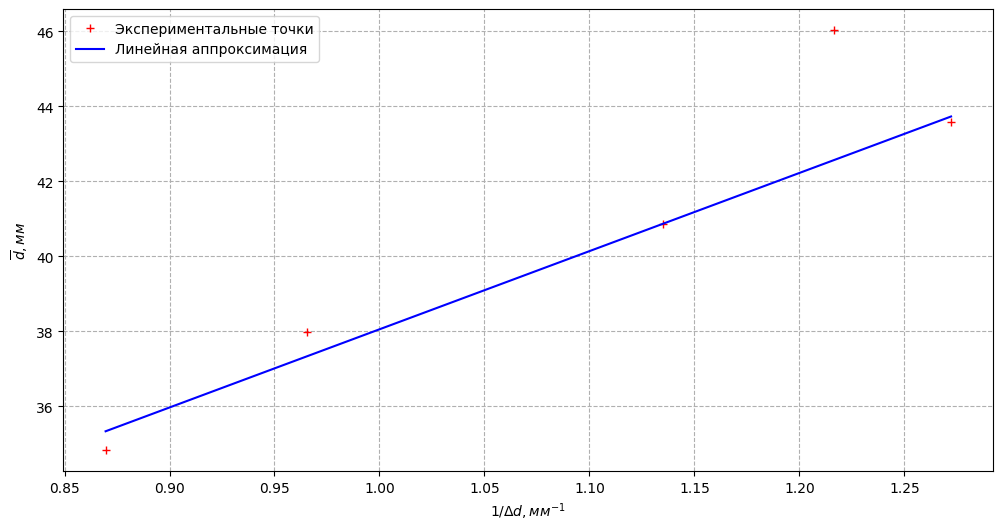

In [70]:
popt_2 = plot(1/delta_d_yellow, over_d_yellow, ejects=[4], xlabel=r"$1/\Delta d, мм^{-1}$", ylabel=r"$\overline{d}, мм$",
     dots_legend="Экспериментальные точки", approx_legend="Линейная аппроксимация", name="graph_yellow")

$$ \Delta \lambda = \cfrac{\lambda \overline{d} \Delta d}{4 f^2} = \cfrac{\lambda k}{4 f^2} $$

In [62]:
k_yellow = popt_2[0]

delta_lambda_yellow = lambdas["yellow"] * k_yellow / 4 / F_ok ** 2

print(f"delta lambda = {delta_lambda_yellow:.1f} A")

delta lambda = 2.5 A


**Пункт 3**

In [63]:
y_na = []
len(data["na"]["x_down"])
x_na = np.arange(min(len(data["na"]["x_down"].dropna()), len(data["na"]["x_up"].dropna()))) + 1

for i in range(len(x_na)):
    y_na.append(
        (data["na"]["x_up"][i] - data["na"]["x_down"][i]) ** 2
    )

y_na = np.array(y_na)

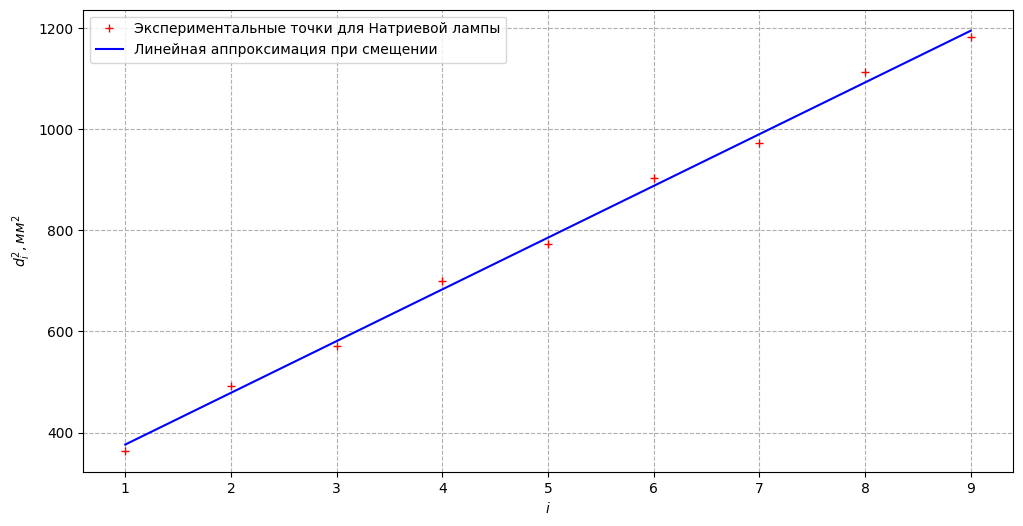

In [64]:
popt_na_1 = plot(x_na, y_na, function=linear_func, xlabel=r"$i$", ylabel=r"$d_i^2, мм^2$", 
     dots_legend="Экспериментальные точки для Натриевой лампы",
     approx_legend="Линейная аппроксимация при смещении", name="graph_na_1")

In [65]:
L_na = lambdas["na"] / 10**10 * 4 * F_ok ** 2 / popt_na_1[0]
print(f"L_na = {(L_na*1000):.3f} mm")

L_na = 0.279 mm


In [66]:
data["na"]

,N_down,x_down,N_up,x_up
0,4,141.915,-4.0,161.000
1,5,140.272,-5.0,162.449
2,6,139.420,-6.0,163.327
3,7,138.209,-7.0,164.652
4,8,137.493,-8.0,165.281
5,9,136.354,-9.0,166.421
6,10,135.800,-10.0,166.973
7,11,134.727,-11.0,168.074
8,12,134.265,-12.0,168.632
9,13,133.301,NaN,NaN


In [67]:
over_d_na, delta_d_na = get_delta_and_overline(data["na"])

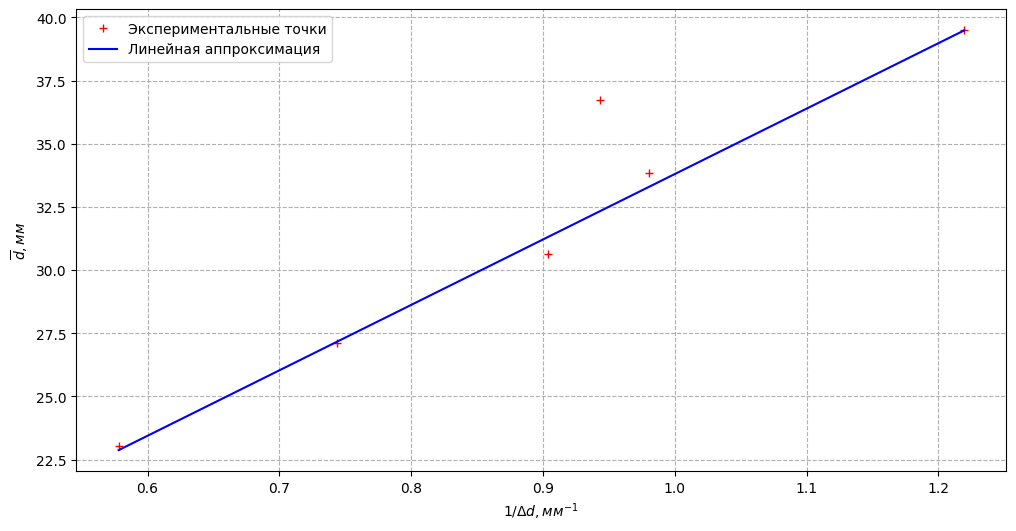

In [71]:
popt_na_2 = plot(1/delta_d_na, over_d_na, ejects=[4], xlabel=r"$1/\Delta d, мм^{-1}$", ylabel=r"$\overline{d}, мм$",
     dots_legend="Экспериментальные точки", approx_legend="Линейная аппроксимация", name="graph_na_2")

In [72]:
k_na = popt_na_2[0]

delta_lambda_na = lambdas["na"] * k_na / 4 / F_ok ** 2

print(f"delta lambda = {delta_lambda_na:.1f} A")

delta lambda = 3.2 A


**Пункт 4**

In [83]:
D_exp = {
    "yellow": delta_d_yellow / 2 / delta_lambda_yellow,
    "na": delta_d_na / 2 / delta_lambda_na
}


D_theor = {
    "yellow": 2 * F_ok ** 2 / lambdas["yellow"] / over_d_yellow,
    "na": 2 * F_ok ** 2 / lambdas["na"] / over_d_na
}

for c in ["yellow", "na"]:
    print(c)
    print("experimental: ", end="")
    for D in D_exp[c]:
        print(f"{D:.3f}", end=" & ")
    print()
    print("      theory: ", end="")
    for D in D_theor[c]:
        print(f"{D:.3f}", end=" & ")
    print()

yellow
experimental: 0.231 & 0.208 & 0.177 & 0.158 & 0.165 & 
      theory: 0.120 & 0.110 & 0.102 & 0.096 & 0.091 & 
na
experimental: 0.274 & 0.213 & 0.175 & 0.162 & 0.168 & 0.130 & 
      theory: 0.178 & 0.151 & 0.134 & 0.121 & 0.112 & 0.104 & 


**Пункт 5**

In [86]:
print(f"m_na = {10**7 * 2 * L_na / lambdas["na"]}")

m_na = 0.9469712571846323


In [87]:
print(f"R_na = {4 * F_ok ** 2 / D_exp["na"][0] / 0.5}")

R_na = 352770.5448774799
